# Application of machine learning and binary classifiers to predict manufacturing yield
### Chet Huang, 15 Dec 2019

## Introduction
This notebook explores the secom dataset hosted by UC Irvine's machine learning repository.  This publicly available dataset was donated in 2008 by Michael McCann and Adrian Johnston.  The dataset is a collection of signals/variables collected from sensors in a modern manufacturing line.  For the purposes of this notebook, we shall treat the sensor readings as those from a hypothetical diaper manufacturing line.  The sensor data consists of 578 attributes from various manufacturing equipment in the diaper factory.  The dataset has 1567 manufactured lots and their associated yield (pass/fail) labels.

The following data flow diagram illustrates how the manufacturing data can feed a statistical process control loop that can predict when a diaper manufacturing lot is likely to pass or fail quality targets.  Armed with such predictions, the hope is that potential yield losses can be detected earlier in the manufacturing process before the diaper heads to final test, assembly and packaging.

This notebook will import the manufacturing data, perform exploratory analysis, clean and prepare the data, build predictive binary classifier models that predict yield loss (yes/no) from sensor readings.  Finally, the notebook will compare results from various models and make recommendations on how best to leverage sensor data to reduce mean time to detect yield loss.

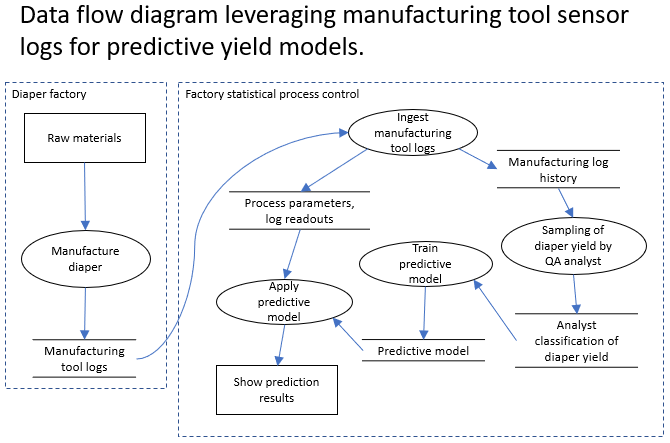

Without further ado, let's begin!

## Import libraries and secom data

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read attribute and label data
filedata = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data'
filelabels = 'https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data'
data = pd.read_csv(filedata, header=None, delimiter=' ')
labels = pd.read_csv(filelabels, header=None, delimiter=' ')
print('data shape:',data.shape)
print('label shape:',labels.shape)

data shape: (1567, 590)
label shape: (1567, 2)


## Exploratory Data Analysis and Data Cleaning

From data source we know that the main data file maps directly with label data file, row for row.  Since date/time is available in the label data, let's use it to index rows in the main data file.

In [3]:
data.index = pd.to_datetime(labels[1].astype(str), format='%d/%m/%Y %H:%M:%S')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,580,581,582,583,584,585,586,587,588,589
1,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602
2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,...,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432
2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,...,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432


We can see that some columns have NaN in them.  Let's get a count of NaNs in each column.

In [4]:
data.isna().sum()

0        6
1        7
2       14
3       14
4       14
5       14
6       14
7        9
8        2
9        2
10       2
11       2
12       2
13       3
14       3
15       3
16       3
17       3
18       3
19      10
20       0
21       2
22       2
23       2
24       2
25       2
26       2
27       2
28       2
29       2
      ... 
560      1
561      1
562    273
563    273
564    273
565    273
566    273
567    273
568    273
569    273
570      0
571      0
572      0
573      0
574      0
575      0
576      0
577      0
578    949
579    949
580    949
581    949
582      1
583      1
584      1
585      1
586      1
587      1
588      1
589      1
Length: 590, dtype: int64

It appears there are columns with just a few NaNs and columns with hundreds of NaNs.  Let's pick a cutoff of 500 NaNs, or about 1/3 of the 1567 rows, and drop columns that have more than 500 NaNs.  We can impute the remaining NaNs with means of their respective columns.

In [5]:
def ImputeColumn(data, col):
    """
    This function either deletes column if more than 500 nan or imputes nan with mean.  Inputs are dataframe called
    data and column index called col
    """
    if data.loc[:,col].isna().sum() > 500:
        data.drop([col], axis=1, inplace=True)
    else:
        imputemean = data.loc[:,col].mean()
        data.loc[:,col].fillna(imputemean, inplace=True)
    return data

for each in range(589,-1,-1):
    data = ImputeColumn(data, each)

In [6]:
# How many columns > 500 nans were dropped?  We started with 590 columns.
data.shape

(1567, 558)

In [7]:
# Double check how many columns have NaN after we either dropped or imputed with mean
data.isna().sum().sum()

0

In [8]:
# Make a copy of data and call it our X for independent variable
X = data.copy()
# Also make a copy of labels data and call it our Yc for our classification target
Yc = labels[0].copy()

As we seek to build and test various binary classifiers to predict whether manufactured lot is good or bad, we should check the binary class distribution.

In [9]:
Yc.value_counts()

-1    1463
 1     104
Name: 0, dtype: int64

From the data source we know that class value 1 is fail, -1 is pass.  Let's map -1 to 0 so class variable is 0/1 for pass/fail.  Some algorithms consider -1, 1 as continuous integers whereas 0, 1 is recognized as binary variable.  Let's also add date/time index to Yc.

In [10]:
Yc.loc[Yc == -1] = 0
Yc.index = pd.to_datetime(labels[1].astype(str), format='%d/%m/%Y %H:%M:%S')

Now let's make a time series plot to see if there's any obvious diaper manufacturing yield problems related to date.

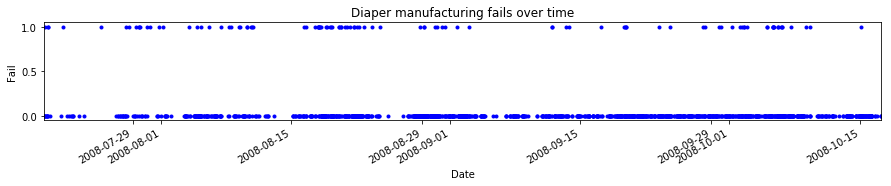

In [11]:
ax = plt.figure(figsize=(15, 2)).gca() # set plot size
Yc.plot(y = '0', ax = ax, style='b.')
ax.set_xlabel('Date')
ax.set_ylabel('Fail')
ax.set_title('Diaper manufacturing fails over time')
plt.show()

The time series plot does reveal (1) there are a few time gaps in the data.  Perhaps the manufacturing line was down causing these gaps.  (2) there are periods of yield problems clusterd in date (e.g., August 2008 was a poor month for diaper yield relative to September 2008).  The overall impression is that there doesn't appear to be an obvious predictable yield problem relative to date.

Let's check summary statistics on the remaining attributes

In [12]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.0,1567.000000,1567.000000,1567.000000,1567.000000,...,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,3014.452896,2495.850231,2200.547318,1396.376627,4.197013,100.0,101.112908,0.121822,1.462862,-0.000841,...,5.563747,16.642363,0.500096,0.015318,0.003847,3.067826,0.021458,0.016475,0.005283,99.670066
std,73.480613,80.227793,29.380932,439.712852,56.103066,0.0,6.209271,0.008936,0.073849,0.015107,...,16.921369,12.485267,0.003403,0.017174,0.003719,3.576891,0.012354,0.008805,0.002866,93.861936
min,2743.240000,2158.750000,2060.660000,0.000000,0.681500,100.0,82.131100,0.000000,1.191000,-0.053400,...,0.663600,4.582000,0.477800,0.006000,0.001700,1.197500,-0.016900,0.003200,0.001000,0.000000
25%,2966.665000,2452.885000,2181.099950,1083.885800,1.017700,100.0,97.937800,0.121100,1.411250,-0.010800,...,1.408450,11.501550,0.497900,0.011600,0.003100,2.306500,0.013450,0.010600,0.003300,44.368600
50%,3011.840000,2498.910000,2200.955600,1287.353800,1.317100,100.0,101.492200,0.122400,1.461600,-0.001300,...,1.624500,13.817900,0.500200,0.013800,0.003600,2.757700,0.020500,0.014800,0.004600,72.023000
75%,3056.540000,2538.745000,2218.055500,1590.169900,1.529600,100.0,104.530000,0.123800,1.516850,0.008400,...,1.902000,17.080900,0.502350,0.016500,0.004100,3.294950,0.027600,0.020300,0.006400,114.749700
max,3356.350000,2846.440000,2315.266700,3715.041700,1114.536600,100.0,129.252200,0.128600,1.656400,0.074900,...,90.423500,96.960100,0.509800,0.476600,0.104500,99.303200,0.102800,0.079900,0.028600,737.304800


We see that the columns have different range of values.  Since we do not have reasons to let one column have more weight than another let's apply min/max normalization to all the columns.

In [13]:
def NormalizeColumn(data, columns):
    """
    This function applies min-max normalization.  Inputs are dataframe called
    data and array called columns
    """
    for each in columns:
        data.loc[:,each] = (data.loc[:,each] - np.min(data.loc[:,each])) \
            / (np.max(data.loc[:,each]) - np.min(data.loc[:,each]))
    return data

for each in range(0,51):
    X = NormalizeColumn(X, X.iloc[:each])

In [14]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,576,577,582,583,584,585,586,587,588,589
1,,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,0.469231,0.589292,0.499096,0.379841,0.000609,NaN,0.328562,0.965785,0.665019,0.542479,...,0.011285,0.112244,0.709375,0.012325,0.017510,0.011880,0.320455,0.173076,0.155193,0.135182
2008-07-19 12:32:00,0.575003,0.445535,0.666763,0.393982,0.000133,NaN,0.428942,0.969673,0.656639,0.412315,...,0.004934,0.068396,0.753125,0.034637,0.036965,0.033099,0.221387,0.220339,0.181159,0.282386
2008-07-19 13:17:00,0.308868,0.583388,0.493903,0.457065,0.000744,NaN,0.283455,0.965008,0.542759,0.448168,...,0.015949,0.050771,0.562500,0.020612,0.021401,0.020152,0.629073,0.589309,0.500000,0.112383
2008-07-19 14:43:00,0.400385,0.466998,0.543479,0.244894,0.000574,NaN,0.469123,0.946345,0.638590,0.319564,...,0.012198,0.043312,0.662500,0.009137,0.007782,0.008734,0.309942,0.152542,0.123188,0.100153
2008-07-19 15:22:00,0.471367,0.500400,0.678327,0.357067,0.000765,NaN,0.387631,0.960342,0.670606,0.392050,...,0.011097,0.069148,0.068750,1.000000,1.000000,1.000000,0.309942,0.152542,0.123188,0.100153


Note that the normalization function has created more columns with NaN.  This is because these columns were just a static value so a min/max normalization produced a NaN.  Let's go ahead and drop these columns since constant value columns have no predictive power.

In [15]:
X.dropna(axis=1,inplace=True)

From above looking at yield class distribution, we have a class imbalance so let's upsample the minority class using SMOTE.

In [16]:
# create a SMOTE object and resample our attributes and targets to balance the classes
sm = SMOTE()
X_res, Yc_res = sm.fit_sample(X, Yc)
X_res = pd.DataFrame(X_res)
Yc_res = pd.DataFrame(Yc_res)

# let's look at the distribution of good (0) and bad (1) before and after SMOTE
print('Before SMOTE:', np.unique(Yc, return_counts=True))
print('After SMOTE:', np.unique(Yc_res, return_counts=True))

Before SMOTE: (array([0, 1], dtype=int64), array([1463,  104], dtype=int64))
After SMOTE: (array([0, 1], dtype=int64), array([1463, 1463], dtype=int64))


Now that classes are balance we reduced risk that majority class will bias our predictive models.

This concludes our initial data exploration and prep.  We will have ~400 features to choose from to build our predictive model.  Let's explore a few different ways to help choose the right features.

We will begin our search by looking for feature correlation.

In [17]:
# let's create another X data frame with class label added to it.  Let's call this class label field 'Fail'
XYc = X_res.copy()
XYc.loc[:,'Fail'] = Yc_res
# we can calculate the correlation coefficient for all columns at once
# corr() conveniently skips all categorical values
Cxyc = XYc.corr()

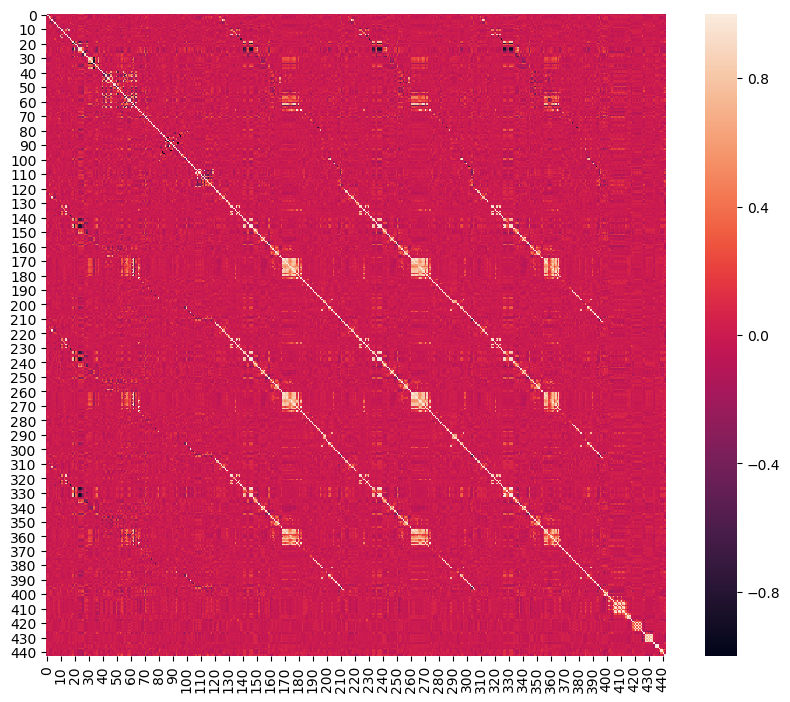

In [25]:
# let's use seaborn to plot the correlations
import seaborn as sns

plt.figure(figsize=(10,8.5), dpi=100)
sns.heatmap(Cxyc)

The correlation heatmap is not very informative because we still have too many features.  There are perhaps a couple of takeaways: (1) there are diagnal correlation lines suggesting some of the features are colinear/proxies; (2) there features that are positively correlated and other features that are negatively correlated.

Let's see if mutual information can give us some insights.

Text(0, 0.5, 'Mutual Information')

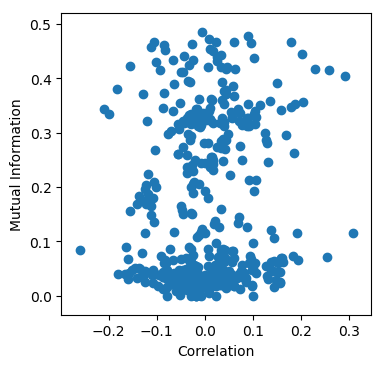

In [18]:
from sklearn.feature_selection import mutual_info_regression

# mutual_info_regression can calculate MI for all features 
# with respect to one outcome variable, but all variables
# must be numerical
cols = Cxyc.index[:-1]
miXYc = pd.DataFrame(index=cols, columns=[])
miXYc.loc[:,'Corr_Fails']= Cxyc.loc['Fail',cols]
miXYc.loc[:,'MI_sklearn'] = mutual_info_regression(XYc[cols],XYc.Fail)

# Plot correlation and mutual information
plt.figure(figsize=(4,4), dpi=100)
plt.scatter(miXYc.Corr_Fails, miXYc.MI_sklearn)
plt.xlabel('Correlation')
plt.ylabel('Mutual Information')

The mutual information chart suggests that many of the features (say, features appearing in lower part of chart) have little predictive power.  We still have too many features and need better ways to identify best features.

Let's use SKLearn's feature_selection to identify 20 attributes that score well for correlation.

In [19]:
from sklearn import feature_selection
skb = feature_selection.SelectKBest(feature_selection.f_classif, k=20)
skb.fit(X_res, np.ravel(Yc_res))
XselectedF5 = skb.transform(X)
X.loc[:,skb.get_support()].head()

,14,21,28,56,59,64,79,95,103,121,122,123,124,125,127,129,130,133,348,510
1,,,,,,,,,,,,,,,,,,,,
2008-07-19 11:55:00,0.329909,0.242124,0.261259,0.902087,0.138291,0.359149,0.306768,0.666667,0.539474,0.688525,0.185512,0.827957,0.746269,0.257061,0.109093,0.598316,0.649733,0.500089,0.053410,0.143240
2008-07-19 12:32:00,0.457039,0.238978,0.487686,0.913323,0.151144,0.299589,0.132827,0.555556,0.533835,0.688525,0.166731,0.795699,0.671642,0.259244,0.113750,0.590733,0.837353,0.435511,0.018598,0.313269
2008-07-19 13:17:00,0.420091,0.238104,0.418016,0.616372,0.267903,0.228662,0.325111,0.611111,0.569549,0.721311,0.232081,0.827957,0.776119,0.263657,0.188148,0.575565,0.852721,0.443796,0.000954,0.533299
2008-07-19 14:43:00,0.425265,0.235237,0.190989,0.616372,0.270716,0.215625,0.786844,0.611111,0.507519,0.147541,0.279992,0.473118,0.238806,0.489502,0.234602,0.651403,0.649947,0.000000,0.144969,0.251524
2008-07-19 15:22:00,0.480818,0.234118,0.185584,0.871589,0.084682,0.607576,0.380772,0.444444,0.533835,0.475410,0.283059,0.602151,0.417910,0.294407,0.252299,0.514879,0.764354,0.312662,0.068193,0.327954


SKLearn's KBest feature selection has chosen the above 20 attributes as having good predictive power.  As an alternative, let's try stepwise feature selection.  This method involves iteratively fitting a model with increasing or decreasing number of features.  Model performance is used as a metric for best features to select.

SciKitLearn has a backward feature selection.  We will use this method and iterate from max to min features while tabulating fitting scores.

In [20]:
# recursive feature elimination requires a model to estimate performance, we choose linear regression
from sklearn import feature_selection
from sklearn.feature_selection import RFE # Recursive Feature Elimination
#from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, roc_auc_score

# let's split our data into train/test sets
X_train, X_test, Yc_train, Yc_test = train_test_split(X_res, Yc_res, train_size=0.7)

## Logistic Regression Classifier
Let's start our stepwise search allowing up to 50 attributes and see how the logistic regression model performs.

# Warning
## This step to permutate feature selection amongst 400+ features took ~23 minutes on my laptop

In [21]:
modelScores = pd.DataFrame(columns=['num','f1_train','f1_test','auc_train','auc_test'])
for i in range(1,50):
    model = LogisticRegression(solver='liblinear')
    rfe = RFE(model, n_features_to_select=i, step=1, verbose=0)
    rfe.fit(X_train, np.ravel(Yc_train))
    Yc_train_pred = rfe.predict(X_train)
    Yc_test_pred = rfe.predict(X_test)
    modelScores = modelScores.append([{'num': i,'f1_train': f1_score(Yc_train, Yc_train_pred),
                                       'f1_test': f1_score(Yc_test, Yc_test_pred),
                                       'auc_train': roc_auc_score(Yc_train, Yc_train_pred),
                                       'auc_test': roc_auc_score(Yc_test, Yc_test_pred)}],ignore_index=True)

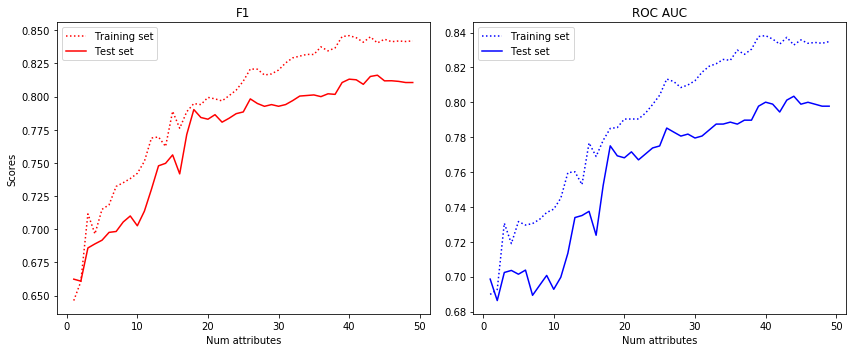

In [22]:
# plot the results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(modelScores.num, modelScores.f1_train, color='r', linestyle=':', label='Training set')
plt.plot(modelScores.num, modelScores.f1_test, color='r', label='Test set')
plt.title('F1')
plt.ylabel('Scores')
plt.xlabel('Num attributes')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(modelScores.num, modelScores.auc_train, color='b', linestyle=':', label='Training set')
plt.plot(modelScores.num, modelScores.auc_test, color='b', label='Test set')
plt.xlabel('Num attributes')
plt.title('ROC AUC')
plt.tight_layout()
plt.legend()

The RFE search suggests that model performance increases rapidly from 1 to 20 features, then starts to flatten.  In keeping with the 20 features selected for KBest, let's see which 20 features are selected by RFE method.

In [23]:
logist = LogisticRegression(solver='liblinear')
rfe = RFE(logist, n_features_to_select=20, step=1, verbose=0)
rfe.fit(X_res, np.ravel(Yc_res))
X_res.loc[:,rfe.get_support()].head()

# Decision tree classifier report
print( classification_report(Yc_res, rfe.predict(X_res)) )

              precision    recall  f1-score   support

           0       0.80      0.76      0.78      1463
           1       0.77      0.82      0.79      1463

    accuracy                           0.79      2926
   macro avg       0.79      0.79      0.79      2926
weighted avg       0.79      0.79      0.79      2926



So we see that KBest and RFE methods selected different attributes for their predictive power.  This is a bit unsettling but a couple of factors might explain this variation.  (1) There over 400 features to select from, (2) Each method uses different optimization techniques to select the best features, and (3) from correlation heat map above we saw that numerous sensor readings are correlated with each other so one selection method might have selected a colinear feature.

### Logistic regression model achieves accuracy of ~78%

## Decision Tree Classifier
Let's use the RFE selected features to build a decision tree classifier to compare model performance with logistic regression.

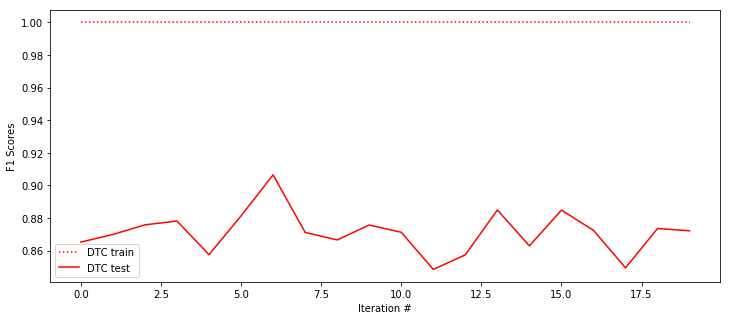

In [24]:
# set up X and Y using SMOTE resampled columns that have been selected through RFE
Xc = X_res.loc[:,rfe.get_support()].copy()
Yc = Yc_res.copy()

# test model with 20 resampled traing/test sets and compare results
modelScores = pd.DataFrame(columns=['num','DTC_train','DTC_test'])

for i in range(0,20):

    X_train, X_test, Y_train, Y_test = train_test_split(Xc, Yc, train_size=0.7)

    # Use dtc and no limits
    model_dtc = DecisionTreeClassifier().fit(X_train, Y_train) 
    Y_dtc_train = model_dtc.predict(X_train)
    Y_dtc_test = model_dtc.predict(X_test)

    # Tabulate F1 scores
    modelScores = modelScores.append([{'num': i,'DTC_train': f1_score(Y_train,Y_dtc_train,average='weighted'),
                                       'DTC_test': f1_score(Y_test,Y_dtc_test,average='weighted')}],ignore_index=True)

# plot the results
plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.plot(modelScores.num, modelScores.DTC_train, color='r', linestyle=':', label='DTC train')
plt.plot(modelScores.num, modelScores.DTC_test, color='r', label='DTC test')
plt.ylabel('F1 Scores')
plt.xlabel('Iteration #')
plt.legend()

Notice that training scores are perfect but test scores are ~87%.  This is a common sign that the model is overfit.  Let's see if we can find better model parameters to reduce the overfitting.  We'll use the cross validate grid search method.

In [25]:
# grid search to find best max_depth and max_leaf_nodes
param_grid = [{'max_depth': [8,16,32,64], 'max_leaf_nodes': [8,16,32,64,128]}]
gsCV = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=24)
gsCV.fit(X_train,Y_train)

print('Best training score: %.3f'%gsCV.best_score_)
print('Corresponding test score: %.3f'%gsCV.score(X_test,Y_test))

gsCV.best_estimator_

Best training score: 0.867
Corresponding test score: 0.883


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=32,
                       max_features=None, max_leaf_nodes=128,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [26]:
# let's check scores for each of the parameter combinations
gsCV_df =  pd.DataFrame(index=np.arange(len(gsCV.cv_results_['mean_fit_time'])),
                        columns=['max_leaf_nodes','max_depth','score'])
for i,d in enumerate(gsCV.cv_results_['params']):
    gsCV_df.loc[i,'max_leaf_nodes'] = d['max_leaf_nodes']
    gsCV_df.loc[i,'max_depth'] = d['max_depth']
    gsCV_df.loc[i,'score'] = gsCV.cv_results_['mean_test_score'][i]
gsCV_df.pivot(index='max_leaf_nodes', columns='max_depth', values='score')

max_depth,8,16,32,64
max_leaf_nodes,,,,
8,0.770996,0.770996,0.770996,0.770996
16,0.787598,0.788086,0.787598,0.788574
32,0.817383,0.818848,0.820801,0.819336
64,0.834473,0.841309,0.843262,0.841309
128,0.834961,0.862305,0.866699,0.864746


From the table above, max_depth/max_leaf_nodes of 16/32 has a score of 85%.  While this score is not as high as 64/128, the chance of overfit is lower with 16/32 so we will choose these parameters for our decision tree model.

Let's check performance of the CV optimized decision tree classifier.

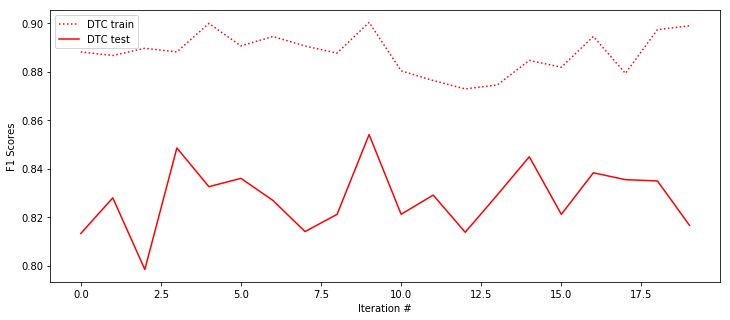

In [27]:
# test model with 20 resampled traing/test sets and compare results
modelScores = pd.DataFrame(columns=['num','DTC_train','DTC_test'])

for i in range(0,20):

    X_train, X_test, Y_train, Y_test = train_test_split(Xc, Yc, train_size=0.7)

    # Use dtc and no limits
    model_dtc = DecisionTreeClassifier(max_depth=16,max_leaf_nodes=32).fit(X_train, Y_train) 
    Y_dtc_train = model_dtc.predict(X_train)
    Y_dtc_test = model_dtc.predict(X_test)

    # Tabulate F1 scores
    modelScores = modelScores.append([{'num': i,'DTC_train': f1_score(Y_train,Y_dtc_train,average='weighted'),
                                       'DTC_test': f1_score(Y_test,Y_dtc_test,average='weighted')}],ignore_index=True)

# plot the results
plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.plot(modelScores.num, modelScores.DTC_train, color='r', linestyle=':', label='DTC train')
plt.plot(modelScores.num, modelScores.DTC_test, color='r', label='DTC test')
plt.ylabel('F1 Scores')
plt.xlabel('Iteration #')
plt.legend()

In [28]:
# Decision tree classifier report
print( classification_report(Y_test, model_dtc.predict(X_test)) )

              precision    recall  f1-score   support

           0       0.81      0.83      0.82       439
           1       0.82      0.80      0.81       439

    accuracy                           0.82       878
   macro avg       0.82      0.82      0.82       878
weighted avg       0.82      0.82      0.82       878



### Decision tree classifier model achieves accuracy score of ~82%

## Ensemble Classifiers
Next let's look at ensemble classifier models.  We'll start with comparison of gradient boosted classifier and random forest classifier with default parameters.

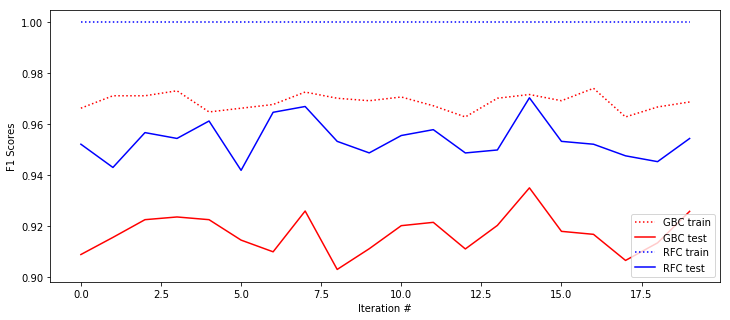

In [29]:
# test model with 20 resampled traing/test sets and compare results
modelScores = pd.DataFrame(columns=['num','GBC_train','GBC_test','RFC_train','RFC_test'])

for i in range(0,20):

    X_train, X_test, Y_train, Y_test = train_test_split(Xc, Yc, train_size=0.7)

    # Use gradient boosting classifier with 100 trees
    model_gbc = GradientBoostingClassifier(n_estimators=100).fit(X_train, np.ravel(Y_train))
    Y_gbc_train = model_gbc.predict(X_train)
    Y_gbc_test = model_gbc.predict(X_test)

    # Use rfc with 100 trees
    model_rfc = RandomForestClassifier(n_estimators=100).fit(X_train, np.ravel(Y_train))
    Y_rfc_train = model_rfc.predict(X_train)
    Y_rfc_test = model_rfc.predict(X_test)
    
    # Tabulate F1 scores
    modelScores = modelScores.append([{'num': i,'GBC_train': f1_score(Y_train,Y_gbc_train,average='weighted'),
                                       'GBC_test': f1_score(Y_test,Y_gbc_test,average='weighted'),
                                       'RFC_train': f1_score(Y_train,Y_rfc_train,average='weighted'),
                                       'RFC_test': f1_score(Y_test,Y_rfc_test,average='weighted')}],ignore_index=True)

# plot the results
plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.plot(modelScores.num, modelScores.GBC_train, color='r', linestyle=':', label='GBC train')
plt.plot(modelScores.num, modelScores.GBC_test, color='r', label='GBC test')
plt.plot(modelScores.num, modelScores.RFC_train, color='b', linestyle=':', label='RFC train')
plt.plot(modelScores.num, modelScores.RFC_test, color='b', label='RFC test')
plt.ylabel('F1 Scores')
plt.xlabel('Iteration #')
plt.legend()

In [30]:
# grid search to find best max_depth and max_leaf_nodes for RFC model
param_grid = [{'max_depth': [2, 4, 8, 16], 'max_leaf_nodes': [8,16,32,64]}]
gsRFCV = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid=param_grid, cv=24)
gsRFCV.fit(X_train,np.ravel(Y_train))

print('best training score (mean on hold out): %.3f'%gsRFCV.best_score_)
print('test score (not given to CV): %.3f'%gsRFCV.score(X_test,Y_test))

gsRFCV.best_estimator_

best training score (mean on hold out): 0.926
test score (not given to CV): 0.926


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=64,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [31]:
# let's check scores for each of the parameter combinations
gsRFCV_df =  pd.DataFrame(index=np.arange(len(gsRFCV.cv_results_['mean_fit_time'])),
                        columns=['max_leaf_nodes','max_depth','score'])
for i,d in enumerate(gsRFCV.cv_results_['params']):
    gsRFCV_df.loc[i,'max_leaf_nodes'] = d['max_leaf_nodes']
    gsRFCV_df.loc[i,'max_depth'] = d['max_depth']
    gsRFCV_df.loc[i,'score'] = gsRFCV.cv_results_['mean_test_score'][i]
gsRFCV_df.pivot(index='max_leaf_nodes', columns='max_depth', values='score')

max_depth,2,4,8,16
max_leaf_nodes,,,,
8,0.773438,0.815918,0.821777,0.820312
16,0.777832,0.82959,0.852539,0.860352
32,0.778809,0.82959,0.893555,0.88916
64,0.770996,0.835449,0.90918,0.925781


In [32]:
# grid search to find best max_depth and max_leaf_nodes for GBC model
param_grid = [{'max_depth': [2, 4, 8, 16], 'max_leaf_nodes': [8,16,32,64]}]
gsGBCV = GridSearchCV(GradientBoostingClassifier(n_estimators=100), param_grid=param_grid, cv=24)
gsGBCV.fit(X_train,np.ravel(Y_train))

print('best training score (mean on hold out): %.3f'%gsGBCV.best_score_)
print('test score (not given to CV): %.3f'%gsGBCV.score(X_test,Y_test))

gsGBCV.best_estimator_

best training score (mean on hold out): 0.956
test score (not given to CV): 0.953


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=16,
                           max_features=None, max_leaf_nodes=32,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [33]:
# let's check scores for each of the parameter combinations
gsGBCV_df =  pd.DataFrame(index=np.arange(len(gsGBCV.cv_results_['mean_fit_time'])),
                        columns=['max_leaf_nodes','max_depth','score'])
for i,d in enumerate(gsGBCV.cv_results_['params']):
    gsGBCV_df.loc[i,'max_leaf_nodes'] = d['max_leaf_nodes']
    gsGBCV_df.loc[i,'max_depth'] = d['max_depth']
    gsGBCV_df.loc[i,'score'] = gsGBCV.cv_results_['mean_test_score'][i]
gsGBCV_df.pivot(index='max_leaf_nodes', columns='max_depth', values='score')

max_depth,2,4,8,16
max_leaf_nodes,,,,
8,0.890137,0.920898,0.92334,0.92334
16,0.890137,0.929199,0.94043,0.940918
32,0.890137,0.927246,0.947754,0.956055
64,0.890137,0.927246,0.954102,0.955566


The grid search results suggest for GBC we should use max_dept of 8, max_leaf_nodes of 16.  The grid search on RFC did not find better parameters than defaults.  Let's check ensemble model performance with the CV optimized parameters.

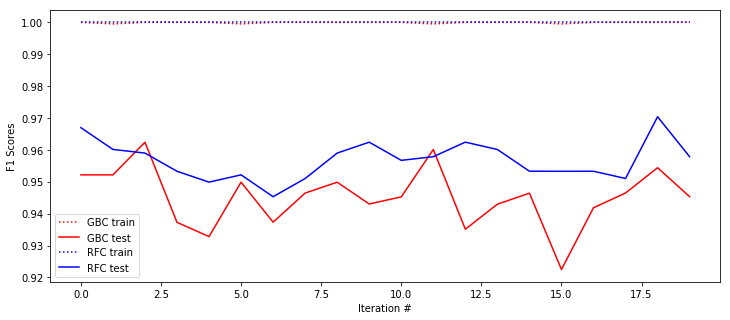

In [34]:
# test model with 20 resampled traing/test sets and compare results
modelScores = pd.DataFrame(columns=['num','DTC_train','DTC_test','RFC_train','RFC_test'])

for i in range(0,20):

    X_train, X_test, Y_train, Y_test = train_test_split(Xc, Yc, train_size=0.7)

    # Use gradient boosting classifier with 100 trees
    model_gbc = GradientBoostingClassifier(max_depth=8,max_leaf_nodes=16,n_estimators=100).fit(X_train, np.ravel(Y_train)) 
    Y_gbc_train = model_gbc.predict(X_train)
    Y_gbc_test = model_gbc.predict(X_test)

    # Use rfc with 100 trees
    model_rfc = RandomForestClassifier(n_estimators=100).fit(X_train, np.ravel(Y_train))
    Y_rfc_train = model_rfc.predict(X_train)
    Y_rfc_test = model_rfc.predict(X_test)
    
    # Tabulate F1 scores
    modelScores = modelScores.append([{'num': i,'GBC_train': f1_score(Y_train,Y_gbc_train,average='weighted'),
                                       'GBC_test': f1_score(Y_test,Y_gbc_test,average='weighted'),
                                       'RFC_train': f1_score(Y_train,Y_rfc_train,average='weighted'),
                                       'RFC_test': f1_score(Y_test,Y_rfc_test,average='weighted')}],ignore_index=True)

# plot the results
plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.plot(modelScores.num, modelScores.GBC_train, color='r', linestyle=':', label='GBC train')
plt.plot(modelScores.num, modelScores.GBC_test, color='r', label='GBC test')
plt.plot(modelScores.num, modelScores.RFC_train, color='b', linestyle=':', label='RFC train')
plt.plot(modelScores.num, modelScores.RFC_test, color='b', label='RFC test')
plt.ylabel('F1 Scores')
plt.xlabel('Iteration #')
plt.legend()

In [35]:
# Decision tree classifier report
print('Random forest classifier report')
print( classification_report(Y_test, model_rfc.predict(X_test)) )
print('\nGradient boosted classifier report')
print( classification_report(Y_test, model_gbc.predict(X_test)) )

Random forest classifier report
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       440
           1       0.96      0.96      0.96       438

    accuracy                           0.96       878
   macro avg       0.96      0.96      0.96       878
weighted avg       0.96      0.96      0.96       878


Gradient boosted classifier report
              precision    recall  f1-score   support

           0       0.96      0.93      0.94       440
           1       0.93      0.96      0.95       438

    accuracy                           0.95       878
   macro avg       0.95      0.95      0.95       878
weighted avg       0.95      0.95      0.95       878



### Both random forest and gradient boosted classifier models achieve accuracy of ~95%

## Support Vector Machine Classifiers
Next let's look at support vector machine models.  We'll start with support vector classifier using default parameters.

In [36]:
# build model with simple linear model and C parameter of 100, then output classicication report
clfSVC = SVC(kernel='linear',C=100,random_state=84)
clfSVC.fit(X_train, np.ravel(Y_train))
print( classification_report(Y_test, clfSVC.predict(X_test)) )

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       440
           1       0.80      0.79      0.80       438

    accuracy                           0.80       878
   macro avg       0.80      0.80      0.80       878
weighted avg       0.80      0.80      0.80       878



Our initial SVC model has an accuracy of 80%.  Let's see if we can do better through a grid search on different hyperparameters.

In [37]:
# grid search for three different kernels and C parameters
param_grid = [{'kernel': ['linear','poly','rbf'], 'C': [1e2,1e3,1e4]}]
gsCV = GridSearchCV(SVC(gamma='auto'), param_grid=param_grid, cv=24)
gsCV.fit(X_train, np.ravel(Y_train))

GridSearchCV(cv=24, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [100.0, 1000.0, 10000.0],
                          'kernel': ['linear', 'poly', 'rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [38]:
# let's check scores for each of the parameter combinations
gsCV_df = pd.DataFrame(index=np.arange(len(gsCV.cv_results_['mean_test_score'])),
                        columns=['kernel','C','score'])
for i,d in enumerate(gsCV.cv_results_['params']):
    gsCV_df.loc[i,'kernel'] = d['kernel']
    gsCV_df.loc[i,'C'] = d['C']
    gsCV_df.loc[i,'score'] = gsCV.cv_results_['mean_test_score'][i]
gsCV_df.pivot(index='kernel', columns='C', values='score')

C,100.0,1000.0,10000.0
kernel,,,
linear,0.791992,0.791992,0.791992
poly,0.790527,0.819824,0.870605
rbf,0.825684,0.866699,0.883789


In [39]:
# grid search for three different kernels and C parameters
param_grid = [{'gamma': [0.1,0.5,1], 'degree': [1,2,3]}]
gsCV = GridSearchCV(SVC(kernel='rbf',C=1000), param_grid=param_grid, cv=24)
gsCV.fit(X_train, np.ravel(Y_train))
# let's check the model scores for each of the parameter combinations
gsCV_df = pd.DataFrame(index=np.arange(len(gsCV.cv_results_['mean_test_score'])),
                        columns=['gamma','degree','score'])
for i,d in enumerate(gsCV.cv_results_['params']):
    gsCV_df.loc[i,'gamma'] = d['gamma']
    gsCV_df.loc[i,'degree'] = d['degree']
    gsCV_df.loc[i,'score'] = gsCV.cv_results_['mean_test_score'][i]
gsCV_df.pivot(index='gamma', columns='degree', values='score')

degree,1,2,3
gamma,,,
0.1,0.875488,0.875488,0.875488
0.5,0.935059,0.935059,0.935059
1.0,0.943848,0.943848,0.943848


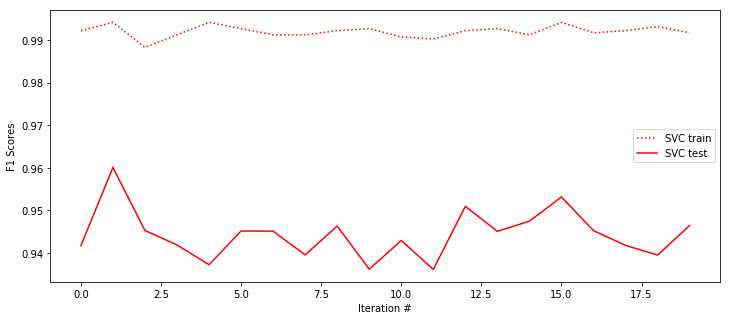

In [40]:
modelScores = pd.DataFrame(columns=['num','SVC_train','SVC_test'])

for i in range(0,20):

    X_train, X_test, Y_train, Y_test = train_test_split(Xc, Yc, train_size=0.7)

    # Use dtc and no limits
    model_svc = SVC(kernel='rbf',C=1000,degree=1,gamma=1).fit(X_train, np.ravel(Y_train))
    Y_svc_train = model_svc.predict(X_train)
    Y_svc_test = model_svc.predict(X_test)

    # Tabulate F1 scores
    modelScores = modelScores.append([{'num': i,'SVC_train': f1_score(Y_train,Y_svc_train,average='weighted'),
                                       'SVC_test': f1_score(Y_test,Y_svc_test,average='weighted')}],ignore_index=True)

# plot the results
plt.figure(figsize=(12, 5))
#plt.subplot(1, 2, 1)
plt.plot(modelScores.num, modelScores.SVC_train, color='r', linestyle=':', label='SVC train')
plt.plot(modelScores.num, modelScores.SVC_test, color='r', label='SVC test')
plt.ylabel('F1 Scores')
plt.xlabel('Iteration #')
plt.legend()

In [41]:
# build model with best hyperparameters from grid search, then output classification report
clfSVC = SVC(kernel='rbf',C=1000,degree=1,gamma=1,random_state=84)
clfSVC.fit(X_train, np.ravel(Y_train))
print( classification_report(Y_test, clfSVC.predict(X_test)) )

              precision    recall  f1-score   support

           0       0.99      0.91      0.95       453
           1       0.91      0.99      0.95       425

    accuracy                           0.95       878
   macro avg       0.95      0.95      0.95       878
weighted avg       0.95      0.95      0.95       878



### Support vector classifier model achieves accuracy of ~95%

## Neural Network Classifiers
Next let's look at neural network (NN) models.  NN models have the benefit of being able to process high dimensions of data and through forward and backward propagation find weights amongst neural nodes to attain the target values.  NN models can do this without the need for feature selection as a data preparation step.

We'll start with simple neural network model with a single hidden layer.

In [42]:
# import TensorFlow and keras for NN modeling
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import layers

In [43]:
# as data prep for our NN model let's use the SMOTE data, but recast dataframe as np.array
tfX = np.asarray(X_res)
tfY = np.asarray(Yc_res.stack().tolist(),dtype=np.int32)

# split the data into test and train sets
tfx_train, tfx_test, tfy_train, tfy_test = train_test_split(tfX, tfY, train_size=0.7)

In [44]:
# build our model with single hidden layer and include dropouts to reduce overfitting
NNclf = tf.keras.Sequential()
NNclf.add(layers.Dense(128, activation='relu', input_shape=(442,)))
NNclf.add(layers.Dropout(0.2))

# add output layer
NNclf.add(layers.Dense(1, activation='sigmoid'))

# use Adam optimizer, for the complete list of optimizers see https://keras.io/optimizers/
optimizer = keras.optimizers.Adam()

# compile the model and set loss to binary cross-entropy since this is a pass/fail binary classification problem
NNclf.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit and predict using 20 epochs
NNclf.fit(tfx_train, tfy_train, validation_data=(tfx_test, tfy_test), epochs=20, batch_size=32, verbose=1)

# After training, output test results
result = NNclf.evaluate(tfx_test, tfy_test, verbose=0)
print('\n\nTest loss, accuracy:', result, '\n\n')

# NN classification report
pred_y = NNclf.predict_classes(tfx_test, batch_size=1)
print(classification_report(tfy_test, pred_y))

Train on 2048 samples, validate on 878 samples
Epoch 1/20
2048/2048 [==============================] - 1s 482us/sample - loss: 0.6644 - accuracy: 0.5874 - val_loss: 0.6132 - val_accuracy: 0.6913
Epoch 2/20
2048/2048 [==============================] - 0s 96us/sample - loss: 0.5855 - accuracy: 0.7178 - val_loss: 0.5621 - val_accuracy: 0.7278
Epoch 3/20
2048/2048 [==============================] - 0s 94us/sample - loss: 0.5349 - accuracy: 0.7524 - val_loss: 0.5328 - val_accuracy: 0.7232
Epoch 4/20
2048/2048 [==============================] - 0s 96us/sample - loss: 0.4972 - accuracy: 0.7788 - val_loss: 0.4875 - val_accuracy: 0.7859
Epoch 5/20
2048/2048 [==============================] - 0s 94us/sample - loss: 0.4789 - accuracy: 0.7817 - val_loss: 0.4644 - val_accuracy: 0.7836
Epoch 6/20
2048/2048 [==============================] - 0s 97us/sample - loss: 0.4427 - accuracy: 0.7979 - val_loss: 0.4396 - val_accuracy: 0.7973
Epoch 7/20
2048/2048 [==============================] - 0s 95us/sample

Our simple neural network with a single hidden layer achieved ~87% accuracy.  Let's see if we can build a better model with two fully connected hidden layers, otherwise known as a deep neural network.

In [45]:
# build our model with 2 fully connected layers and include dropouts to reduce overfitting
DNNclf = tf.keras.Sequential()
DNNclf.add(layers.Dense(128, activation='relu', input_shape=(442,)))
DNNclf.add(layers.Dropout(0.2))
DNNclf.add(layers.Dense(128, activation='relu'))
DNNclf.add(layers.Dropout(0.3))

# add output layer
DNNclf.add(layers.Dense(1, activation='sigmoid'))

# use Adam optimizer, for the complete list of optimizers see https://keras.io/optimizers/
optimizer = keras.optimizers.Adam()

# compile the model and set loss to binary cross-entropy since this is a pass/fail binary classification problem
DNNclf.compile(optimizer = optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Fit and predict using 20 epochs
DNNclf.fit(tfx_train, tfy_train, validation_data=(tfx_test, tfy_test), epochs=20, batch_size=32, verbose=1)

# After training, output test results
result = DNNclf.evaluate(tfx_test, tfy_test, verbose=0)
print('\n\nTest loss, accuracy:', result)

Train on 2048 samples, validate on 878 samples
Epoch 1/20
2048/2048 [==============================] - 1s 351us/sample - loss: 0.6722 - accuracy: 0.5684 - val_loss: 0.6359 - val_accuracy: 0.6276
Epoch 2/20
2048/2048 [==============================] - 0s 117us/sample - loss: 0.5982 - accuracy: 0.6802 - val_loss: 0.5282 - val_accuracy: 0.7517
Epoch 3/20
2048/2048 [==============================] - 0s 109us/sample - loss: 0.5033 - accuracy: 0.7637 - val_loss: 0.4716 - val_accuracy: 0.7745
Epoch 4/20
2048/2048 [==============================] - 0s 100us/sample - loss: 0.4591 - accuracy: 0.7925 - val_loss: 0.4172 - val_accuracy: 0.8087
Epoch 5/20
2048/2048 [==============================] - 0s 103us/sample - loss: 0.4126 - accuracy: 0.8149 - val_loss: 0.4003 - val_accuracy: 0.8394
Epoch 6/20
2048/2048 [==============================] - 0s 103us/sample - loss: 0.3885 - accuracy: 0.8271 - val_loss: 0.3964 - val_accuracy: 0.8462
Epoch 7/20
2048/2048 [==============================] - 0s 99us/s

The DNN model achieves similar accuracy to the RFC, GDC, and SVM classifiers.  The beauty of the DNN model is that it did not require us to perform feature selection as part of the data preparation step.  The drawback is that the model is somewhat of a mystery 'black box' in that the relationships between input attributes are difficult to coerce out.

Let's check the classification report to see how the model performed with the binary classification.

In [46]:
# DNN classification report
pred_y = DNNclf.predict_classes(tfx_test, batch_size=1)
print(classification_report(tfy_test, pred_y))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       438
           1       0.95      0.99      0.97       440

    accuracy                           0.97       878
   macro avg       0.97      0.97      0.97       878
weighted avg       0.97      0.97      0.97       878



### Deep Neural Network model achieves accuracy of ~97%

# Summary
The diaper manufacturing line is able to supply 590 sensor readings from the diaper manufacturing process.  These sensor readings have predictive capability on diaper manufacturing yield.  We used KBest, RFE techniques to identify which attributes have best predictive power to determine yield.  We found that KBest and RFE selected different attributes, likely due to their different approaches to feature selection.  Various predictive models were then built, and model hyperparameters were tweaked through cross validated grid search.  Neural network models were also built.  All these efforts help highlight and contrast the different approaches with using machine learning to solve this binary classification problem.

The model performance (accuracy) results are:
<br>Logistic regression: ~78%
<br>Decision tree classifier: ~82%
<br>Random forest classifier: ~95%
<br>Gradient boosted classifier: ~94%
<br>Support vector machine classifier: ~95%
<br>Deep Neural Network classifier: ~97%

# Final recommendations for Diaper Manufacturing Company
As a means to detect manufacturing yield, the sensor data from the various manufacturing equipment should be consolidated and fed into a deep neural network (DNN) classifier model.  While the DNN model has predictive accuracy on par with other models, it is superior for a few reasons:
<br>1) DNN model is tolerant to amount of incoming sensor data, no need to narrow down inputs to key attributes which can be problematic if the key sensors are malfunctioning
<br>2) DNN models can be inrementally taught and improved upon with incremental data, resulting in significant time savings
<br>3) DNN models are more scalable as both the training can be accelerated with multiple CPU or GPU cores running in parallel

For these reasons my recommendation is to use a DNN classifier model to predict manufacturing yield.

Superior reasons to chose DNN classifier aside, the exploratory data analysis portion of this study identified the top 20 key sensors that are leading indicators for manufacturing yield.  These key sensors are sensor numbers 14, 21, 28, 56, 59, 64, 79, 95, 103, 121, 122, 123, 124, 125, 127, 129, 130, 133, 348, 510.  If key sensor data can be collected as soon as available and fed into our yield model, then it would greatly reduce the mean-time-to-detect potential yield loss.  The sooner potential yield problems can be detected and addressed, the greater the overall factory productivity.  For these reasons, it is also important to ensure that these sensors are periodically calibrated and follow strict statistical process control guidelines.